# Imports

In [1]:
%matplotlib inline

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import imageio
from io import BytesIO

# Global variables

In [2]:
WIDTH = 120
HEIGHT = 120
OS = "linux"
test_size = 0.2
label_name = ["palm_horizontal", "L", "fist_horizontal", "fist_vertical", "thumb_up", "index", "ok", "palm_vertical", "C", "thumb_down"]

# Loading data

In [3]:
def load_labelling_data(width, height, oper_sys):
	X = []
	y = []
	stop = False
	if oper_sys == "windows":
		split_ = "\\"
	else:
		split_ = "/"
	for root, _, files in tqdm(os.walk(".", topdown=False)): 
		for name in files:
			path = os.path.join(root, name)
			if path.endswith("jpg"):
				# if path.split(split_)[-1][0] != ".":
				if path.split(split_)[-1][0].isalpha():
					# Loading images
					img = cv2.imread(path)
					img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
					img = cv2.resize(img, (width, height))
					X.append(img)
					# Loading labels
					category = path.split(split_)[-1].split("_")[0]
					# label = int(category.split("_")[0]) - 1
					y.append(category)
	X = np.array(X)
	y = np.array(y)
	return X.reshape(X.shape[0], height, width, 1), y

def load_dataset_data(width, height, oper_sys):
    X = []
    y = []
    stop = False
    if oper_sys == "windows":
        split_ = "\\"
    else:
        split_ = "/"
    for root, dirs, files in tqdm(os.walk(".", topdown=False)): 
        for name in files:
            path = os.path.join(root, name)
            if path.endswith("png"):
                # Loading labels
                category = path.split(split_)[4]
                label = int(category.split("_")[0]) - 1
                y.append(label)
                # Loading images
                img = cv2.imread(path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (width, height))
                X.append(img)
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], height, width, 1), y

def get_background_images():
	images = []
	with open('data_background/test.mkv', 'rb') as file: 
		content = file.read()
	vid = imageio.get_reader(BytesIO(content),  'ffmpeg')
	images = []
	for num, image in enumerate(vid.iter_data()): 
		if num % 14 == 0:
			img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)[:,:,np.newaxis]
			images.append(img)
	return np.array(images)

In [4]:
X_labelling, y_labelling = load_labelling_data(WIDTH, HEIGHT, OS)
background_images = get_background_images()

116it [00:00, 383.88it/s]


In [5]:
print(X_labelling.shape)
print(y_labelling.shape)
print(background_images.shape)

(99, 120, 120, 1)
(99,)
(104, 720, 960, 1)


# Data augmentation

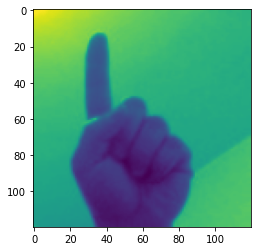

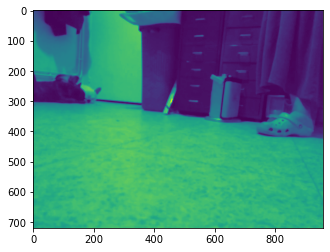

In [6]:
plt.imshow(X_labelling[0])
plt.show()
plt.imshow(background_images[0])
plt.show()

In [7]:
def add_background_to_data(background_images, hand_images, labels):
	final_images = []
	new_labels = []
	for idx, hand_img in enumerate(tqdm(hand_images)):
		for background_img in background_images:
			for r in range(1, 4):
				resize = int(hand_img.shape[0]*r)
				hand_img_resized = cv2.resize(hand_img, (resize, resize))[:,:,np.newaxis]
				y_offset = np.random.randint(background_img.shape[0] - hand_img_resized.shape[0])
				x_offset = np.random.randint(background_img.shape[1] - hand_img_resized.shape[1])
				tmp = background_img.copy()
				tmp[y_offset:y_offset+hand_img_resized.shape[0], x_offset:x_offset+hand_img_resized.shape[1]] = hand_img_resized
				final_images.append(tmp)
				new_labels.append(labels[idx])
	return np.array(final_images), np.array(new_labels)

In [8]:
X, y = add_background_to_data(background_images[:5], X_labelling, y_labelling)
print(X.shape)
print(y.shape)

100%|██████████| 99/99 [00:01<00:00, 58.98it/s] 


(1485, 720, 960, 1)
(1485,)


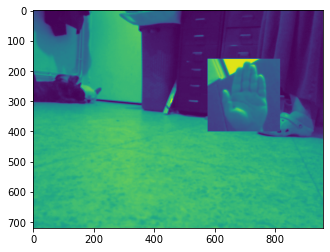

In [10]:
plt.imshow(X[1000])

In [11]:
_, y = np.unique(y, return_inverse=True) ## Converts to categorical int
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Building model

In [12]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(len(label_name), activation='softmax'))
    return model

# Training model

In [13]:
train_ = True

if train_ :
    model = build_model()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))
    model.save('tmp_model.h5')
else:
    model = tf.keras.models.load_model("tmp_model.h5", custom_objects=None, compile=True, options=None)

model.summary()
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

2022-04-03 16:46:14.299133: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-03 16:46:14.300920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-03 16:46:14.305063: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-03 16:46:16.065293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-03 16:46:16.070114: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2592000000 Hz


Epoch 1/5


Error: Canceled future for execute_request message before replies were done

# Inference

: 